# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
gradient=False

In [31]:
%matplotlib inline
import pandas as pd, numpy as np
from pathlib import Path
import sys
sys.path.append('../')

In [4]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'dev-notebooks'/'data'/'drug'
RAWDATA = DATA/'raw'
LOCALDATA = DATA/'interim'

if gradient:
    IMGDATA = Path('/storage/molimages')
else:
    # Path to image data as defined earlier
    IMGDATA = Path('/data-ssd/data/drug')

In [5]:
from fastai.vision.all import *

# Load data

In [12]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = "_".join(str(data.stem).split("_")[:2])
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    return df[['CID', 'SMILES', 'Image', 'Activity']], name

We remember that we had 7 activity datasets:

In [13]:
# Datasets available:
data = sorted(list(LOCALDATA.ls(file_exts='.csv')))
data

[Path('/data-ssd/Dropbox/Jobb/projects/ML/medGPU1-alex/PCS956-DL-2021/2-intro_to_practical_dl/dev-notebooks/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv')]

...and that we've generated images of the molecules:

In [14]:
IMGDATA.ls()

(#7) [Path('/data-ssd/data/drug/CHEMBL240_cl'),Path('/data-ssd/data/drug/CHEMBL301_cl'),Path('/data-ssd/data/drug/CHEMBL219_cl'),Path('/data-ssd/data/drug/CHEMBL244_cl'),Path('/data-ssd/data/drug/CHEMBL205_cl'),Path('/data-ssd/data/drug/CHEMBL1978_cl'),Path('/data-ssd/data/drug/CHEMBL218_cl')]

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [15]:
ds = data[0]
ds

Path('/data-ssd/Dropbox/Jobb/projects/ML/medGPU1-alex/PCS956-DL-2021/2-intro_to_practical_dl/dev-notebooks/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv')

In [16]:
df, name = get_df(ds)

/tmp/ipykernel_15249/1099125352.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')


In [17]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       6831 non-null   object
 1   SMILES    6831 non-null   object
 2   Image     6831 non-null   object
 3   Activity  6831 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 213.6+ KB


In [19]:
df['Activity'].value_counts()

0    6210
1     621
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [22]:
df = val_cols_and_oversample(df)

In [23]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False
1,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False
2,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False
3,CHEMBL1957218,s1cc(nc1-c1ccncc1C)-c1cccnc1,CHEMBL1957218.png,1,False
4,CHEMBL1957223,s1cc(nc1-c1cccnc1)-c1ccc(OC)nc1,CHEMBL1957223.png,1,False


In [24]:
df['Activity'].value_counts()

0    6210
1    4815
Name: Activity, dtype: int64

# Create a dataloader

In [25]:
bs=64

In [26]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [27]:
IMGDATA

Path('/data-ssd/data/drug')

In [28]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [29]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

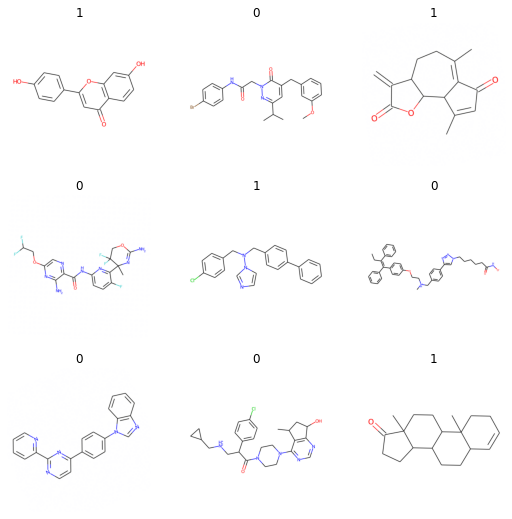

In [30]:
dls.show_batch()

# Train a CNN

In [35]:
# Copied from here: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, endnames=-1, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:endnames]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [36]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [37]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [42]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

The below training takes a while. We can rather load the results of a previous run:

In [39]:
#learn = learn.load('chembl1978-model-test-hooks')

/home/alex/anaconda3/envs/pcs956/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


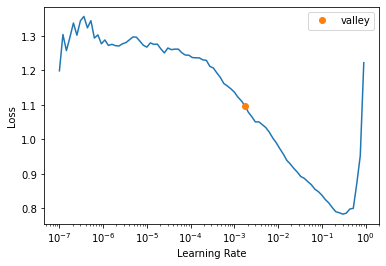

In [44]:
lr = learn.lr_find()

In [45]:
lr

SuggestedLRs(valley=0.001737800776027143)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.238991,0.127476,0.954918,0.785515,0.691176,0.909677,0.978323,0.769817,00:38


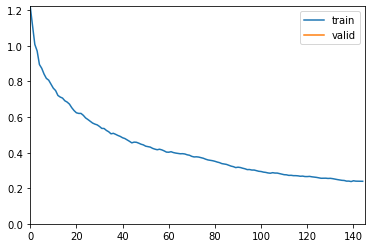

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.127066,0.180350,0.939110,0.736041,0.606695,0.935484,0.980832,0.724482,00:47
1,0.111178,0.129244,0.960187,0.751825,0.865546,0.664516,0.970820,0.738135,00:46
2,0.088340,0.141834,0.960187,0.810056,0.714286,0.935484,0.978691,0.797219,00:46
3,0.063858,0.108594,0.973068,0.853503,0.842767,0.864516,0.976985,0.838759,00:46
4,0.045126,0.097579,0.977166,0.872131,0.886667,0.858065,0.979008,0.859738,00:46
5,0.025912,0.091688,0.974824,0.866044,0.837349,0.896774,0.978834,0.852778,00:46
6,0.018765,0.090291,0.978337,0.879479,0.888158,0.870968,0.979852,0.867629,00:47
7,0.013475,0.089444,0.979508,0.884488,0.905405,0.864516,0.980450,0.873533,00:46


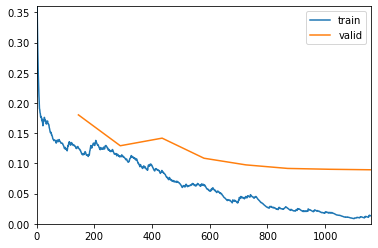

In [46]:
learn.freeze()
learn.fit(1, lr.valley)
learn.unfreeze()
learn.fit_one_cycle(8, slice(lr.valley))

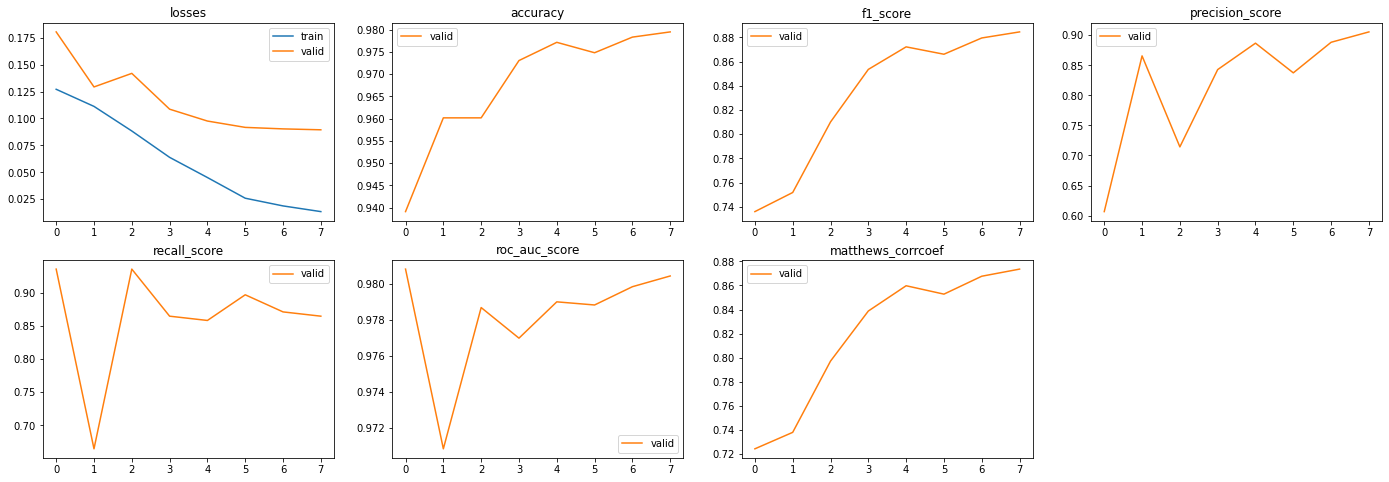

In [47]:
learn.recorder.plot_metrics()

In [48]:
learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

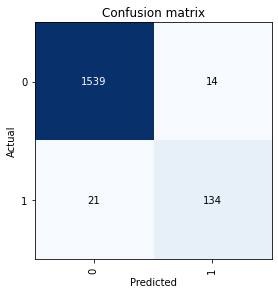

In [50]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a "hook" at the layer we want to save activations from:

In [51]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [52]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [53]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [54]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

/tmp/ipykernel_15249/1099125352.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')


No data augmentation:

In [55]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [56]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [57]:
test_df = test_dls.items.reset_index()

In [58]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,5655,CHEMBL180157,Clc1ccc(cc1)CC(NC(=O)c1cc2c(nc1)cccc2)C(=O)N1CCN(CC1)c1ccccc1N(S(=O)(=O)C)CC1CC1,CHEMBL180157.png,0,True
1,687,CHEMBL400795,s1cnc(C)c1CCOc1cc2Cc3c([nH]nc3-c3ccc(nc3)C#N)-c2cc1OC,CHEMBL400795.png,0,True
2,4999,CHEMBL473186,Fc1c2c(cccc2)c(cc1)-c1nc(nc(c1)C(C)C)N,CHEMBL473186.png,0,False
3,2983,CHEMBL2374418,O1C(CO)C(O)C(O)C1n1c2nc(nc(N)c2nc1)NCCC1CCCC1,CHEMBL2374418.png,0,True
4,1924,CHEMBL1934527,S(=O)(=O)(CC1OCCCC1)c1ccc(cc1)-c1ccc(cc1)CC[NH+]1CCCC1C,CHEMBL1934527.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [59]:
test_dls.dataset[0]

(PILImage mode=RGB size=500x500, TensorCategory(0))

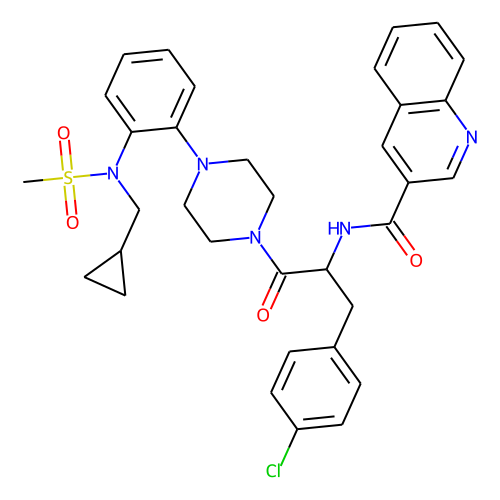

In [60]:
test_dls.dataset[0][0]

In [61]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [62]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [106]:
#df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')
#df_acts.head()

In [63]:
%%time
%%capture
df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

CPU times: user 24min 8s, sys: 22.3 s, total: 24min 30s
Wall time: 1min 32s


Now we've stored activations for each image:

In [64]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,"[-6.184187, 1.4444413, 0.521848, 3.279325, 2.1758714, -3.622425, 0.19396251, -0.21029639, -4.0048776, -8.043223, -0.518915, 5.063404, -2.0837214, -2.9376814, -1.9549924, 1.1289828, -4.780456, -6.515083, -1.9355012, -3.503919, -0.4543544, 9.377184, -3.5737062, 6.1095676, -5.335267, 10.252796, 1.0168297, 2.2123225, 11.024843, 8.120278, 6.41325, 8.914105, 11.815174, -6.5244417, -7.3803015, -0.83202, 11.011935, 4.980705, -1.1987529, -3.386364, -2.8172069, 6.7828274, -5.5876365, 2.5186515, 8.564585, -1.8924102, 11.676276, -4.8863964, -3.4049675, 9.232604, -6.9650064, 1.4842341, -2.8685398, 0.70..."
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,"[-5.7409472, 2.3540854, 1.7673556, 5.295206, 7.6774397, -7.558473, -3.9700027, -0.5143206, -7.5064807, -7.109574, 1.1101311, 5.8202877, -3.6978326, -3.345647, -3.3418272, 3.6064825, -7.4744635, -5.564231, -6.6542726, -2.5185099, 2.7870357, 11.167856, -2.577325, 7.7280188, -9.864266, 13.808397, 2.248811, 4.625309, 12.003161, 8.536922, 8.689267, 12.117384, 15.552018, -3.9567611, -6.3115087, 1.5006623, 13.636204, 8.030262, -7.4689627, -2.4979975, -5.354964, 5.9168773, -3.0862699, 3.439574, 8.730666, -4.6508484, 11.409047, -2.5085616, -7.2829685, 10.752849, -11.400724, 5.0579033, -2.4669127, 1..."
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,"[-5.756766, -0.4546344, 0.04205066, 0.3078282, -2.5595055, 5.279199, 5.035797, -4.6806936, 1.9669814, -6.2800922, -4.1548223, 4.0622077, 2.618632, -1.9932114, -1.891407, 0.15517163, 2.7460577, -3.110406, 4.9269743, -2.5240958, -0.4369572, 3.7696195, -4.976178, 0.07118696, 4.073591, -0.17857403, -0.45211774, -1.5893087, 3.268244, 1.7159326, 6.462378, 3.9982195, 4.511472, -9.30704, -1.2095838, -7.119926, 0.9931544, -2.4953759, 5.0792613, -4.178006, -1.1834445, 2.3542414, -4.834479, 4.2929616, 3.2756915, 1.8213415, 6.887765, -5.7386274, 2.255372, 3.8423886, 1.9276986, 3.5908468, -1.8244487, 1..."
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,"[1.2929709, 3.998208, 3.2907565, 7.458484, 2.7031574, -5.788347, -3.2932436, -5.454589, -7.2700686, -8.084206, -2.375199, 5.4174643, -3.9942052, -4.7686024, -1.2680446, -1.5132841, -7.092613, -7.758236, -2.333228, -3.2110057, 4.807523, 14.43173, -7.2173805, 12.829014, -9.402982, 14.026573, 2.3720548, -0.15979709, 8.61222, 13.161034, 2.4736075, 3.4227073, 9.975694, -6.715244, -7.8170605, 2.7941558, 14.773541, 3.8527815, -1.2558165, -1.0426623, 0.06799802, 2.043833, -4.2687564, -0.68117404, 9.702319, -3.718126, 12.105204, -3.221354, -7.011573, 9.972218, -9.315399, 2.141772, -6.1826377, -1.07..."
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,"[-0.9110375, 0.20199826, 1.3658652, 4.5987215, 3.9869099, -4.379489, -2.1974149, -5.90267, -7.6268516, -6.994688, -3.9651027, 3.4222183, -4.3296394, -6.2628274, -1.4178525, -1.0188286, -6.3266, -6.33528, -2.4668224, -3.7337787, 2.2271845, 14.919674, -7.278125, 10.962722, -7.678695, 12.403084, 1.845382, -2.9237444, 9.304751, 10.845649, 4.3577337, 5.3755026, 11.492593, -6.648832, -7.3447943, 0.027745247, 14.284081, 3.9999712, -0.45243067, -2.4012194, -0.025592, -0.34416962, -4.4080424, -2.0670383, 9.28961, -3.3665185, 9.459005, -2.3373148, -5.16068, 10.105173, -7.540802, 4.730282, -5.7070465..."


We split the activations to have one column for each, as they will be treated as separate features later:

In [65]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [66]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [67]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,-6.184187,1.444441,0.521848,3.279325,2.175871,...,-0.253255,7.728647,4.196553,7.744170,2.833343,-5.833090,2.175440,9.715018,-6.697997,-3.916421
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,-5.740947,2.354085,1.767356,5.295206,7.677440,...,3.305871,8.696218,4.001807,9.674870,3.959525,-4.367425,5.987826,11.699579,-9.215359,-5.988041
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,-5.756766,-0.454634,0.042051,0.307828,-2.559505,...,-1.710156,0.551617,3.877632,3.636263,1.602630,-4.822006,-3.375687,4.011164,2.491900,2.675303
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,1.292971,3.998208,3.290756,7.458484,2.703157,...,6.483366,17.466084,0.221648,11.706307,0.246143,-7.070720,11.904807,13.065377,-4.679908,-5.611359
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,-0.911038,0.201998,1.365865,4.598722,3.986910,...,3.851789,15.585896,1.355715,11.832880,-0.197730,-6.419633,9.892677,14.316216,-4.364078,-4.033681


In [68]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 3.6+ MB


In [69]:
df_acts.to_csv('data/chembl1978_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `dev-noteboos/DL-Example-3-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [70]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [71]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


In [73]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 3.6+ MB


In [74]:
df = df_ecfp.merge(df_acts, on='CID')

In [75]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-0.253255,7.728647,4.196553,7.744170,2.833343,-5.833090,2.175440,9.715018,-6.697997,-3.916421
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,3.305871,8.696218,4.001807,9.674870,3.959525,-4.367425,5.987826,11.699579,-9.215359,-5.988041
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-1.710156,0.551617,3.877632,3.636263,1.602630,-4.822006,-3.375687,4.011164,2.491900,2.675303
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,6.483366,17.466084,0.221648,11.706307,0.246143,-7.070720,11.904807,13.065377,-4.679908,-5.611359
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,3.851789,15.585896,1.355715,11.832880,-0.197730,-6.419633,9.892677,14.316216,-4.364078,-4.033681


In [76]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [77]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-0.253255,7.728647,4.196553,7.744170,2.833343,-5.833090,2.175440,9.715018,-6.697997,-3.916421
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,3.305871,8.696218,4.001807,9.674870,3.959525,-4.367425,5.987826,11.699579,-9.215359,-5.988041
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-1.710156,0.551617,3.877632,3.636263,1.602630,-4.822006,-3.375687,4.011164,2.491900,2.675303
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,6.483366,17.466084,0.221648,11.706307,0.246143,-7.070720,11.904807,13.065377,-4.679908,-5.611359
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,3.851789,15.585896,1.355715,11.832880,-0.197730,-6.419633,9.892677,14.316216,-4.364078,-4.033681


In [78]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [79]:
LOCALDATA

Path('/data-ssd/Dropbox/Jobb/projects/ML/medGPU1-alex/PCS956-DL-2021/2-intro_to_practical_dl/dev-notebooks/data/drug/interim')

In [80]:
df.to_csv('data/chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [81]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [82]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [83]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [84]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,3.305871,8.696218,4.001807,9.674870,3.959525,-4.367425,5.987826,11.699579,-9.215359,-5.988041
3,0,0,0,0,0,0,0,0,0,0,...,6.483366,17.466084,0.221648,11.706307,0.246143,-7.070720,11.904807,13.065377,-4.679908,-5.611359
4,0,0,0,0,0,0,0,0,0,0,...,3.851789,15.585896,1.355715,11.832880,-0.197730,-6.419633,9.892677,14.316216,-4.364078,-4.033681
5,0,0,0,0,0,0,0,0,0,0,...,0.246589,4.500792,7.697244,8.449679,3.419328,-6.521668,3.045133,11.977139,-7.729894,-3.796851
8,0,0,0,0,0,0,0,0,0,0,...,2.686651,5.610452,2.036967,6.985032,1.618249,-6.104956,3.035102,8.846895,-2.985255,-4.508418


In [85]:
y_train.head()

1    1
3    1
4    1
5    1
8    1
Name: Activity, dtype: int64

### A logistic regression model

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [87]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [88]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f'AUC: {auc}')
    print(f'Accuracy: {acc2}')
    print(f'MCC: {mcc}')
    print(f'Recall: {Recall}')
    print(f'Precision: {Precision}')
    print(f'F1_score: {F1_score}')

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [89]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.9844421826641464
Accuracy: 0.9754098360655737
MCC: 0.8518754972513235
Recall: 0.8709677419354839
Precision: 0.8598726114649682
F1_score: 0.8653846153846154


In [90]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.9801258749974037
Accuracy: 0.9765807962529274
MCC: 0.8521996070868413
Recall: 0.8129032258064516
Precision: 0.9197080291970803
F1_score: 0.8630136986301369


In [91]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.9810730531956879
Accuracy: 0.977751756440281
MCC: 0.8617284923630204
Recall: 0.8451612903225807
Precision: 0.903448275862069
F1_score: 0.8733333333333334
